# BIG DATA ASSIGNMENT WEEK 13
## Linear Regression
- Name: Kurnia Cahya Febryanto
- Student ID: 5025201073
- Class: Big Data A
- Lecturer: Abdul Munif, S.Kom., M.Sc.

## Reference
https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

## Load the data

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=b29242580fd18e3968c138d6134e45aaf5a4edf8fec87e0fbb5d9132ef4fc408
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [9]:
!kaggle competitions download -c boston-housing

  0% 0.00/13.9k [00:00<?, ?B/s]
100% 13.9k/13.9k [00:00<00:00, 13.3MB/s]


In [12]:
!unzip boston-housing.zip

Archive:  boston-housing.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [15]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

try:
    sc = SparkContext.getOrCreate()
except ValueError:
    print('SparkContext already exists')
    
sqlContext = SQLContext(sc)
# boston.csv change to 
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train.csv')
house_df.take(1)


[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

## Data exploration
Print Schema in a tree format.

In [16]:
house_df.cache()
house_df.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



Perform descriptive analytics

In [17]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables.

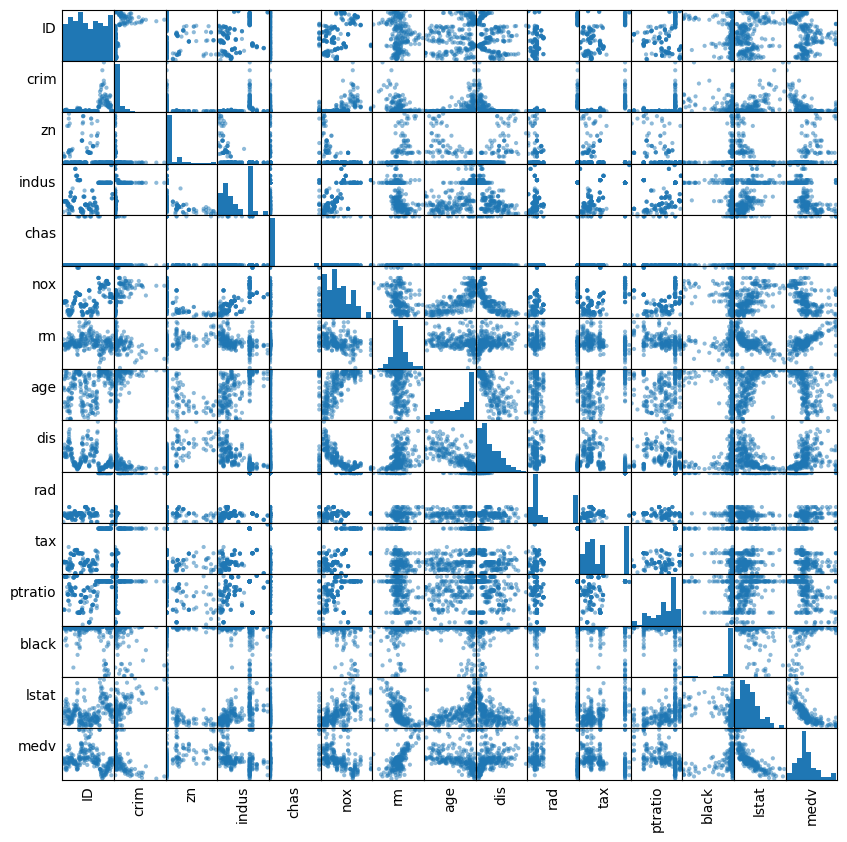

In [19]:
import pandas as pd
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())


It’s hard to see. Let’s find correlation between independent variables and target variable.

In [21]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to medv for ", i, house_df.stat.corr('medv',i))

Correlation to medv for  ID -0.22169418651611697
Correlation to medv for  crim -0.4074543235732598
Correlation to medv for  zn 0.34484197569664277
Correlation to medv for  indus -0.47393197065920345
Correlation to medv for  chas 0.20438998859918733
Correlation to medv for  nox -0.4130541519920783
Correlation to medv for  rm 0.6895980892872156
Correlation to medv for  age -0.35888827406190227
Correlation to medv for  dis 0.24942226829396397
Correlation to medv for  rad -0.3522508242456341
Correlation to medv for  tax -0.44807769440070433
Correlation to medv for  ptratio -0.48137595552491735
Correlation to medv for  black 0.33665955532155767
Correlation to medv for  lstat -0.7386000348786346
Correlation to medv for  medv 1.0


The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median value tends to go up when the number of rooms goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; the median value tends to go down when the percentage of the lower status of the population goes up. Finally, coefficients close to zero mean that there is no linear correlation.

We are going to keep all the variables, for now.

Prepare data for Machine Learning. And we need two columns only — features and label(“MV”):

In [23]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



In [24]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

## Linear Regression

In [26]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [0.0,0.021507313829074774,0.0,4.0871901847364365,-6.035305409107409,3.6777048640827203,0.0,-0.7818466877584105,-0.0,-2.3869611138306612e-05,-0.61416193446205,0.006952056807257512,-0.5692076776359031]
Intercept: 21.536810161412067


In [27]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.928600
r2: 0.700231


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual “MV” value, such as mean, min and max. After such comparison, our RMSE looks pretty good.

In [28]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               237|
|   mean|22.485654008438832|
| stddev|  9.02086827899073|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



R squared at 0.74 indicates that in our model, approximate 74% of the variability in “MV” can be explained using the model. This is in align with the result from Scikit-Learn. It is not bad. However, we must be cautious that the performance on the training set may not a good approximation of the performance on the test set.

In [30]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|20.571010624126597|20.1|[0.01965,80.0,1.7...|
| 38.65618436953352|50.0|[0.02009,95.0,2.6...|
| 30.83707528188743|31.1|[0.02187,60.0,2.9...|
| 27.79719139372257|23.9|[0.02543,55.0,3.7...|
| 25.05613846793943|21.6|[0.02731,0.0,7.07...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.712105


In [31]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.09848


Sure enough, we achieved worse RMSE and R squared on the test set.

In [32]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.49999999999999956, 0.434155960922669, 0.25029971654048716, 0.22737340045869306, 0.196395124706569, 0.19271420723745636, 0.19111744700097946, 0.19039523590906202, 0.18938483499206712, 0.18807312623116262, 0.1879030181346086]
+-------------------+
|          residuals|
+-------------------+
| -6.180978138655021|
| 1.9149148253778137|
| -5.046717999743503|
|  1.857320928197062|
|  5.483739255584823|
| 0.9281874267915242|
| 0.6313129694056983|
|-1.2703393320135739|
|-2.8707271475256135|
| 7.7295582422299205|
|  1.807231543539281|
| -3.072572639442466|
| 7.9594436924751975|
|-1.3244225305018098|
| -9.075086690242856|
| -2.351023371049301|
|  4.050599690151845|
|-1.8480515942849998|
|  2.345722226734452|
|-1.1927777516304836|
+-------------------+
only showing top 20 rows



Using our Linear Regression model to make some predictions:

In [34]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|20.571010624126597|20.1|[0.01965,80.0,1.7...|
| 38.65618436953352|50.0|[0.02009,95.0,2.6...|
| 30.83707528188743|31.1|[0.02187,60.0,2.9...|
| 27.79719139372257|23.9|[0.02543,55.0,3.7...|
| 25.05613846793943|21.6|[0.02731,0.0,7.07...|
|29.644665941474116|30.8|[0.02763,75.0,2.9...|
|25.704116178897408|26.6|[0.02899,40.0,1.2...|
|29.279276547631515|31.2|[0.03049,55.0,3.7...|
|28.038161750654414|24.1|[0.03445,82.5,2.0...|
|24.726557089713097|22.9|[0.03551,25.0,4.8...|
|23.039028147540137|20.7|[0.03738,0.0,5.19...|
|28.093232733564562|28.0|[0.04113,25.0,4.8...|
|25.041405196626222|20.6|[0.04294,28.0,15....|
|23.547631903802706|20.5|[0.04337,21.0,5.6...|
| 25.95663416840062|22.3|[0.0459,52.5,5.32...|
| 27.01573336478466|27.1|[0.05372,0.0,13.9...|
|28.057498096465416|24.6|[0.05425,0.0,4.05...|
| 21.48105955402423|19.0|[0.05497,0.0,5.19...|
| 34.15032661

## Decision tree regression

In [36]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.95775


## Feature Importance

In [37]:
dt_model.featureImportances

SparseVector(13, {0: 0.0477, 1: 0.0001, 4: 0.0047, 5: 0.5592, 6: 0.0081, 7: 0.0909, 8: 0.0006, 9: 0.0245, 10: 0.0215, 11: 0.0022, 12: 0.2406})

In [38]:
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

Apparently, the number of rooms is the most important feature to predict the house median price in our data.

## Gradient-boosted tree regression

In [40]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|20.354745561747254|20.1|[0.01965,80.0,1.7...|
|  37.7965028880572|50.0|[0.02009,95.0,2.6...|
|31.752354808685546|31.1|[0.02187,60.0,2.9...|
|25.094382747582703|23.9|[0.02543,55.0,3.7...|
|23.120709717400718|21.6|[0.02731,0.0,7.07...|
+------------------+----+--------------------+
only showing top 5 rows



Gradient-boosted tree regression performed the best on our data.